In [27]:
import tensorflow as tf
import pyarrow as pa

In [22]:
import numpy as np
from io import BytesIO
from PIL import Image

In [68]:
images = []
path = r"C:\Users\Cristiano Lavoro\Downloads\tpu-getting-started\tfrecords-jpeg-192x192\train\00-192x192-798.tfrec"

In [93]:
raw_dataset = tf.data.TFRecordDataset(path)

In [94]:
for item,label in raw_dataset:
    image = tf.io.decode_raw(item, tf.uint8)
    print(image.numpy().shape)
    break

TypeError: Cannot iterate over a scalar tensor.

In [77]:
feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),  # For image data (stored as bytes)
}

In [78]:
def _parse_function(example_proto):
    # Parse the input tf.train.Example proto using the feature description dictionary
    return tf.io.parse_single_example(example_proto, feature_description)

# Apply the parsing function to the dataset
parsed_dataset = raw_dataset.map(_parse_function)

In [79]:
for parsed_record in parsed_dataset.take(1):
    image_raw = parsed_record['image_raw'].numpy()  # Raw bytes for the image
    
    # Do something with the features, like decoding the image
    print(f'Image: {image_raw[:20]}...')  # Preview the first few bytes

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:67 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::ParallelMapV2: Feature: image_raw (data type: string) is required but could not be found.
	 [[{{node ParseSingleExample/ParseExample/ParseExampleV2}}]] [Op:IteratorGetNext] name: 

# Tensorflow dataset loading

In [3]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.17.0


In [59]:
path = r"C:\Users\rober\Downloads\tpu-getting-started\tfrecords-jpeg-512x512\train\00-512x512-798.tfrec"

In [60]:
IMAGE_SIZE = [512,512]

In [62]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [63]:
dataset = load_dataset(path, labeled=True, ordered=False)

(512, 512, 3)
Label: 57


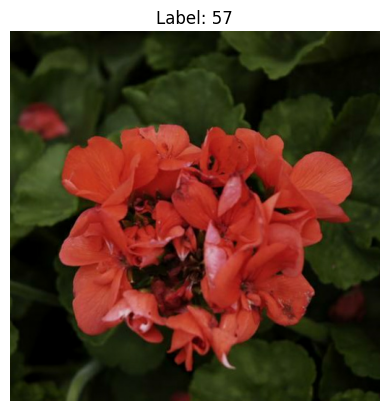

In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Load the dataset from a single .tfrec file
dataset = load_dataset(path, labeled=True, ordered=True)

#dataset = dataset.skip(37) #per prendere un'immagine specifica: in questo caso voglio vedere la 38

# Step 2: Take a single image and label from the dataset
for image, label in dataset.take(1): 
    print(image.numpy().shape) # .take(1) grabs a single sample
    # Step 3: Print the label
    print(f"Label: {label.numpy()}")
    
    # Step 4: Display the image
    plt.imshow(image.numpy())  # Convert the tensor to a numpy array
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')  # Turn off axes
    plt.show()


In [10]:
directory = "C:/Users/rober/Downloads/tpu-getting-started/tfrecords-jpeg-192x192/train/"  # Replace with your actual directory path

# Create a list of filenames with two-digit formatting and specific naming
filenames = [os.path.join(directory, f"{i:02}-192x192-798.tfrec") for i in range(15)]  # 00 to 15
filenames.append(os.path.join(directory, f"15-192x192-783.tfrec"))
# Assume you have a list of filenames for your .tfrec files

# Step 1: Load all the .tfrec files into a single dataset
dataset = load_dataset(filenames=filenames, labeled=True, ordered=True)

# Step 2: Create a set to hold unique labels
unique_classes = set()
class_counts = {}

# Step 3: Iterate through the dataset to extract labels
for _, label in dataset:
    unique_classes.add(label.numpy())  # Add each label to the set
    label_value = label.numpy()  # Convert label to numpy for easier handling
    if label_value in class_counts:
        class_counts[label_value] += 1  # Increment count for the class
    else:
        class_counts[label_value] = 1  # Initialize count for a new class
# Step 4: Display the counts for each class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

# Step 4: Count the unique classes
num_classes = len(unique_classes)

print(f"Total number of different classes across all files: {num_classes}")


Class 57: 58 images
Class 10: 133 images
Class 82: 125 images
Class 102: 360 images
Class 94: 121 images
Class 70: 95 images
Class 22: 46 images
Class 77: 135 images
Class 64: 52 images
Class 8: 83 images
Class 28: 113 images
Class 1: 26 images
Class 75: 287 images
Class 50: 191 images
Class 49: 530 images
Class 43: 101 images
Class 13: 245 images
Class 56: 81 images
Class 25: 79 images
Class 4: 669 images
Class 32: 22 images
Class 73: 437 images
Class 103: 700 images
Class 19: 25 images
Class 72: 158 images
Class 93: 130 images
Class 18: 81 images
Class 53: 428 images
Class 86: 117 images
Class 71: 127 images
Class 14: 209 images
Class 0: 261 images
Class 48: 404 images
Class 47: 245 images
Class 67: 749 images
Class 45: 162 images
Class 79: 111 images
Class 52: 105 images
Class 21: 92 images
Class 95: 117 images
Class 30: 97 images
Class 16: 53 images
Class 27: 30 images
Class 78: 78 images
Class 46: 118 images
Class 91: 109 images
Class 61: 27 images
Class 101: 24 images
Class 68: 2

In [14]:
class_counts[103]

700

### Conversione del dataset di tensorflow nel nostro framework

In [ ]:
#prima cosa: creare la table --> devo creare il sample
#il sample è di questo tipo:

#sample:
# |__image
# |__label

#quindi devo spacchettare il dataset e riorganizzarlo in questo modo

In [28]:
import io
import framework_functions as ff

In [44]:
root_path = "C:/Users/rober/Downloads/tpu-getting-started/tfrecords-jpeg-192x192/train/" 
save_path = "C:/Users/rober/onedrive/desktop/projects/benchmarks2.0/benchmarks/PetalsToMetal/train"

filenames = [os.path.join(root_path, f"{i:02}-192x192-798.tfrec") for i in range(15)]
filenames.append(os.path.join(directory, f"15-192x192-783.tfrec"))
dataset = load_dataset(filenames=filenames, labeled=True, ordered=True) #carico tutti i .tfrec di train
output = []
for image, label in dataset:
    class_index = label.numpy()
    numpy_array = image.numpy()
    numpy_array = (numpy_array * 255).astype(np.uint8)
    image = Image.fromarray(numpy_array)
    byte_arr = io.BytesIO()
    image.save(byte_arr, format='JPEG')
    byte_array = byte_arr.getvalue()

    sample = {
        "image_feature":[
            {
                "image" : byte_array,
                "class_feature":[
                    {
                        "label" : class_index
                    }
                ]
            }
        ]
    }
    output.append(sample)
table = pa.Table.from_pylist(output)
ff.partition_dataset(table,save_path)



In [45]:
len(table)

12753

In [58]:
%pip install timm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.3 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 6.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.8/199.4 MB 4.2 MB/s eta 0:00:48
   ---------------------------------------- 2.4/199.4 MB 6.1 MB/s eta 0:00:33
    --------------------------------------- 3.4/199.4 MB 6.5 MB/s eta 0:00:31
    --------------------------------------- 5.0/199.4 MB 6.3 MB/s eta 0:00:31
   - -------------------------------------- 6.3/199.4 MB 6.4 MB/s eta 0:00:31
   - -------------------------------------- 7.6/199.4 MB 6.2 MB/s eta 0:00:32
   - -------------------------------------- 8.9/199.4 MB 6.3 MB/s eta 0:00:31
   -- ------------------------------------- 10.5/199.4 MB 6.4 MB/s eta 0:00:30
   --

In [69]:
import timm

C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [71]:
model = timm.create_model('tf_efficientnet_b0', num_classes=104, pretrained = True)

C:\Users\rober\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\.cache\huggingface\hub\models--timm--tf_efficientnet_b0.ns_jft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
model